In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from sklearn import preprocessing
from collections import Counter
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt

In [139]:
#显示所有列，把行显示设置成最大
pd.set_option('display.max_columns', None)

In [163]:
df = pd.read_csv('附件/MergeResult.csv',engine='python')

df.head(3)

carid    pushDate  pushPrice   updatePriceTimeJson    pullDate  \
0  68603  2021-03-11       3.98                    {}  2021-03-11   
1  12312  2021-05-14       4.50                    {}  2021-06-14   
2  57655  2021-03-13      23.90  {"2021-04-05": "23"}  2021-04-08   

  withdrawDate  brand  serial  model  mileage  color  cityId  carCode  \
0   2021-03-11     47     314  11903    11.80      1       1      2.0   
1   2021-06-14     62     797   3174     3.87      4       2      1.0   
2   2021-04-08      8     196  10320     1.64      2       3      4.0   

   transferCount  seatings   country  maketype  displacement  gearbox  \
0            1.0       5.0  779414.0       2.0           1.8      3.0   
1            0.0       5.0  779413.0       1.0           1.4     23.0   
2            1.0       5.0  779412.0       1.0           2.0      7.0   

   oiltype  newprice  feature1  feature2  feature3  feature5  feature6  \
0        1     15.89       1.0         2         2        51         2   
1        1      9.28       1.0         1         2        71         1   
2        1     34.00       1.0         8         2        10         2   

   feature8  feature9  feature10  feature11  feature14  price  \
0       1.0       4.0       3.00        2.0          1   3.98   
1       2.0       5.0       2.00        2.0          2   4.50   
2       2.0       4.0       2.98        2.0          2  23.00   

   feature12-length  feature12-width  feature12-height  feature12-volume  \
0            4620.0           1780.0            1498.0      1.231895e+10   
1            4195.0           1780.0            1622.0      1.211164e+10   
2            5074.0           1893.0            1489.0      1.430197e+10   

   tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
0                   388.0                  383.0                  7.0   
1                   193.0                  182.0                  4.0   
2                   101.0                   73.0                  2.0   

   tradeTime-feature13  
0                 88.0  
1                 44.0  
2                 27.0

In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   carid                   10000 non-null  int64  
 1   pushDate                10000 non-null  object 
 2   pushPrice               10000 non-null  float64
 3   updatePriceTimeJson     10000 non-null  object 
 4   pullDate                10000 non-null  object 
 5   withdrawDate            8000 non-null   object 
 6   brand                   10000 non-null  int64  
 7   serial                  10000 non-null  int64  
 8   model                   10000 non-null  int64  
 9   mileage                 10000 non-null  float64
 10  color                   10000 non-null  int64  
 11  cityId                  10000 non-null  int64  
 12  carCode                 10000 non-null  float64
 13  transferCount           10000 non-null  float64
 14  seatings                10000 non-null 

## 一、预处理

### 1、表示分类标签

In [164]:
df.loc[~pd.isna(df['withdrawDate']),'withdrawDate'] = 1
df.loc[pd.isna(df['withdrawDate']),'withdrawDate'] = 0
df['withdrawDate'].value_counts()

1    8000
0    2000
Name: withdrawDate, dtype: int64

### 2、计算时间跨度

In [145]:
# 计算pullDate-pushDate：以周为单位
pushDate = pd.to_datetime(df['pushDate'])
pullDate = pd.to_datetime(df['pullDate'])

delta_pull_push = pullDate-pushDate
#以周为单位
delta_weeks_pp = []
for delta in delta_pull_push:
    if delta.days % 7 <= 3:
        weeks = delta.days//7
    else:
        weeks = delta.days//7 + 1
    delta_weeks_pp.append(weeks)

#加入数据集
df.insert(df.shape[1],'pull_pushTime',delta_weeks_pp)
#删除pullDate列
# df = df.drop(df[["pullDate"]],axis=1)
df.head()

carid    pushDate  pushPrice     updatePriceTimeJson    pullDate  \
0  68603  2021-03-11     3.9800                      {}  2021-03-11   
1  12312  2021-05-14     4.5000                      {}  2021-06-14   
2  57655  2021-03-13    23.9000    {"2021-04-05": "23"}  2021-04-08   
3  45688  2020-09-01    20.5798                      {}  2020-09-04   
4  52081  2021-04-29    12.2800  {"2021-05-20": "11.9"}  2021-06-21   

  withdrawDate  brand  serial  model  mileage  color  cityId  carCode  \
0            1     47     314  11903    11.80      1       1      2.0   
1            1     62     797   3174     3.87      4       2      1.0   
2            1      8     196  10320     1.64      2       3      4.0   
3            1     42     845   8504    10.45      6       1      2.0   
4            1      2     187   9521     5.66      6      19      2.0   

   transferCount  seatings   country  maketype  displacement  gearbox  \
0            1.0       5.0  779414.0       2.0           1.8      3.0   
1            0.0       5.0  779413.0       1.0           1.4     23.0   
2            1.0       5.0  779412.0       1.0           2.0      7.0   
3            0.0       2.0  779412.0       3.0           2.9     31.0   
4            1.0       5.0  779415.0       2.0           2.0     11.0   

   oiltype  newprice  feature1  feature2  feature3  feature5  feature6  \
0        1     15.89       1.0         2         2        51         2   
1        1      9.28       1.0         1         2        71         1   
2        1     34.00       1.0         8         2        10         2   
3        1     82.13       1.0        13         2        43        13   
4        1     22.98       1.0         5         2         2         1   

   feature8  feature9  feature10  feature11  feature14    price  \
0       1.0       4.0       3.00        2.0          1   3.9800   
1       2.0       5.0       2.00        2.0          2   4.5000   
2       2.0       4.0       2.98        2.0          2  23.0000   
3       1.0       2.0       2.00        2.0          1  20.5798   
4       1.0       5.0       2.00        2.0          1  11.9000   

   feature12-length  feature12-width  feature12-height  feature12-volume  \
0            4620.0           1780.0            1498.0      1.231895e+10   
1            4195.0           1780.0            1622.0      1.211164e+10   
2            5074.0           1893.0            1489.0      1.430197e+10   
3            4342.0           1801.0            1292.0      1.010337e+10   
4            4570.0           1845.0            1670.0      1.408086e+10   

   tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
0                   388.0                  383.0                 7.00   
1                   193.0                  182.0                 4.00   
2                   101.0                   73.0                 2.00   
3                   522.0                  509.0                10.21   
4                   346.0                  336.0                 8.00   

   tradeTime-feature13  update_num  pull_pushTime  
0                 88.0           0              0  
1                 44.0           0              4  
2                 27.0           1              4  
3                115.0           0              0  
4                 93.0           1              8

In [143]:
#计算价格变动次数：如果前面已经算过，就不需要运行了
str_slice = pd.Series(df["updatePriceTimeJson"]) 
info = [s for s in str_slice.str.split()]

update_num=[]
for i in info:
    if len(i)>=2:
        update_num.append(int(len(i)/2))
    else:
        update_num.append(0)

df.insert(df.shape[1], 'update_num', update_num)

In [9]:
#计算调整价格的时间跨度
updates = df['updatePriceTimeJson']
last_updateTime = []
for times in updates:
    dates = list(eval(times).keys())
    if dates != []:
        date = pd.to_datetime(dates[-1])
        last_updateTime.append(date)
    else:
        last_updateTime.append(0)

#计算时间弹性
date_length = []
for i,date in enumerate(last_updateTime):
    if date != 0:
        T = (date-pushDate[i]).days
        date_length.append(1/T)
    else:
        date_length.append(0)
        
df.insert(df.shape[1], 'update_T_el', date_length)
df.head(3)

carid    pushDate  pushPrice   updatePriceTimeJson withdrawDate  brand  \
0  68603  2021-03-11       3.98                    {}            1     47   
1  12312  2021-05-14       4.50                    {}            1     62   
2  57655  2021-03-13      23.90  {"2021-04-05": "23"}            1      8   

   serial  model  mileage  color  ...  feature12-width  feature12-height  \
0     314  11903    11.80      1  ...           1780.0            1498.0   
1     797   3174     3.87      4  ...           1780.0            1622.0   
2     196  10320     1.64      2  ...           1893.0            1489.0   

   feature12-volume  tradeTime-registerDate  tradeTime-licenseDate  \
0      1.231895e+10                   388.0                  383.0   
1      1.211164e+10                   193.0                  182.0   
2      1.430197e+10                   101.0                   73.0   

   tradeTime-modelyear  tradeTime-feature13  pull_pushTime  update_num  \
0                  7.0                 88.0              0           0   
1                  4.0                 44.0              4           0   
2                  2.0                 27.0              4           1   

   update_T_el  
0     0.000000  
1     0.000000  
2     0.043478  

[3 rows x 42 columns]

### 3.计算价格变动跨度

In [10]:
#提取最后一次的变动价格
str_slice = pd.Series(df["updatePriceTimeJson"]) 
info = [s for s in str_slice.str.split()]
last_price=[]
for i in info:
    if len(i)>=2:
        tmp=i[-1].split("}")
        tmp[0]=tmp[0].replace("\"", "")
        last_price.append(tmp[0])
    else:
        last_price.append("*")

for i in range(len(last_price)):
    if last_price[i]=='*':
        last_price[i]=df.loc[i,"pushPrice"]
    else:
        last_price[i]=float(last_price[i])
        
#delta_price代表的是相对与原价格的变动幅度
delta_price=[]
for i in range(len(last_price)):
    delta_price.append((df.loc[i,"pushPrice"]-last_price[i])/df.loc[i,"pushPrice"])

df.insert(df.shape[1], 'delta_price', delta_price)
df.head(3)

carid    pushDate  pushPrice   updatePriceTimeJson withdrawDate  brand  \
0  68603  2021-03-11       3.98                    {}            1     47   
1  12312  2021-05-14       4.50                    {}            1     62   
2  57655  2021-03-13      23.90  {"2021-04-05": "23"}            1      8   

   serial  model  mileage  color  ...  feature12-height  feature12-volume  \
0     314  11903    11.80      1  ...            1498.0      1.231895e+10   
1     797   3174     3.87      4  ...            1622.0      1.211164e+10   
2     196  10320     1.64      2  ...            1489.0      1.430197e+10   

   tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
0                   388.0                  383.0                  7.0   
1                   193.0                  182.0                  4.0   
2                   101.0                   73.0                  2.0   

   tradeTime-feature13  pull_pushTime  update_num  update_T_el  delta_price  
0                 88.0              0           0     0.000000     0.000000  
1                 44.0              4           0     0.000000     0.000000  
2                 27.0              4           1     0.043478     0.037657  

[3 rows x 43 columns]

In [11]:
#删除列
df.drop(labels=['pushDate','updatePriceTimeJson'],axis=1,inplace=True)
df.head(3)

carid  pushPrice withdrawDate  brand  serial  model  mileage  color  \
0  68603       3.98            1     47     314  11903    11.80      1   
1  12312       4.50            1     62     797   3174     3.87      4   
2  57655      23.90            1      8     196  10320     1.64      2   

   cityId  carCode  ...  feature12-height  feature12-volume  \
0       1      2.0  ...            1498.0      1.231895e+10   
1       2      1.0  ...            1622.0      1.211164e+10   
2       3      4.0  ...            1489.0      1.430197e+10   

   tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
0                   388.0                  383.0                  7.0   
1                   193.0                  182.0                  4.0   
2                   101.0                   73.0                  2.0   

   tradeTime-feature13  pull_pushTime  update_num  update_T_el  delta_price  
0                 88.0              0           0     0.000000     0.000000  
1                 44.0              4           0     0.000000     0.000000  
2                 27.0              4           1     0.043478     0.037657  

[3 rows x 41 columns]

In [12]:
df.to_csv('第二问特征抽取后.csv')

In [13]:
df['pull_pushTime'].describe()

count    10000.000000
mean         3.154300
std          3.935942
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         40.000000
Name: pull_pushTime, dtype: float64

## 4、导入编码后的全部数据

In [85]:
df = pd.read_csv('附件/第二问编码后的数据.csv')
df.drop(labels='carid',axis=1,inplace=True)
df.head(3)

pushPrice  withdrawDate  brand    serial     model  mileage  color  cityId  \
0       3.98             1    185  0.156757  0.172414    11.80   8489    8801   
1       4.50             1     11  0.090909  1.000000     3.87   1586     252   
2      23.90             1   2686  0.003723  0.200000     1.64   4157    1254   

   carCode  transferCount  seatings  country  maketype  displacement  gearbox  \
0        0              1         5        0         0           1.8        0   
1        0              0         5        0         0           1.4        0   
2        0              1         5        0         0           2.0        0   

   oiltype  newprice  feature1  feature2  feature3  feature5  feature6  \
0    20321     15.89         0      5482     20619       183     10118   
1    20321      9.28         0       635     20619        11      6209   
2    20321     34.00         0      1772     20619      1084     10118   

   feature8  feature9  feature10  feature11  feature14  price  \
0         0         0          0          0      12731   3.98   
1         0         0          0          0       8190   4.50   
2         0         0          0          0       8190  23.00   

   feature12-length  feature12-width  feature12-height  feature12-volume  \
0              4620             1780              1498       12318952800   
1              4195             1780              1622       12111636200   
2              5074             1893              1489       14301967098   

   tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
0                     388                    383                  7.0   
1                     193                    182                  4.0   
2                     101                     73                  2.0   

   tradeTime-feature13  pull_pushTime  update_num  update_T_el  delta_price  
0                 88.0              0           0     0.000000     0.000000  
1                 44.0              4           0     0.000000     0.000000  
2                 27.0              4           1     0.043478     0.037657

## 二、预测问题

In [90]:
#提取成交的数据，划分X,y
X = df.loc[df['withdrawDate']==1,:].drop(labels='pull_pushTime',axis=1)
y = df.loc[df['withdrawDate']==1,'pull_pushTime']

#划分训练集和测试集
from sklearn.model_selection import  train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

print("X_train.shape:",X_train.shape)
print("X_test.shape:",X_test.shape)
print("y_train.shape:",y_train.shape)
print("y_test.shape:",y_test.shape)

X_train.shape: (6400, 39)
X_test.shape: (1600, 39)
y_train.shape: (6400,)
y_test.shape: (1600,)


## 1、标准化

In [91]:
# 归一化处理：选择性运行这一个代码块，如果前面已经归一化过了，就不需要在运行一遍了

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_sc = min_max_scaler.transform(X_train)
X_test_sc = min_max_scaler.transform(X_test)

In [92]:
#array封装到DataFrame
X_train_sc = pd.DataFrame(X_train_sc,columns=X_test.columns,index=y_train.index)
X_test_sc = pd.DataFrame(X_test_sc,columns=X_test.columns,index=y_test.index)

In [93]:
X_test_sc

pushPrice  withdrawDate     brand    serial     model   mileage  \
5761   0.016463           0.0  0.455324  0.047681  0.007309  0.200000   
4258   0.028350           0.0  0.554356  0.257453  0.026201  0.258108   
7753   0.004256           0.0  1.000000  0.100363  0.006214  0.397297   
375    0.012814           0.0  1.000000  0.018409  0.028271  0.219189   
4679   0.013271           0.0  0.096798  0.087924  0.020590  0.049730   
...         ...           ...       ...       ...       ...       ...   
365    0.014365           0.0  1.000000  0.123087  0.015411  0.197027   
3069   0.020293           0.0  0.455324  0.013318  0.028271  0.036486   
6921   0.002280           0.0  0.177960  0.101981  0.009041  0.221081   
1236   0.018591           0.0  0.043187  0.189177  0.021579  0.070541   
6038   0.011933           0.0  0.621742  0.054532  0.009707  0.358108   

         color    cityId  carCode  transferCount  seatings  country  maketype  \
5761  0.488669  0.000795      0.0       0.000000  0.428571      0.0       0.0   
4258  1.000000  0.107601      0.0       0.111111  0.428571      0.0       0.0   
7753  0.326133  0.047040      0.0       0.111111  0.428571      0.0       0.0   
375   0.142823  0.115101      0.0       0.000000  0.428571      0.0       0.0   
4679  1.000000  0.107601      0.0       0.000000  0.428571      0.0       0.0   
...        ...       ...      ...            ...       ...      ...       ...   
365   0.218366  1.000000      0.0       0.000000  0.428571      0.0       0.0   
3069  0.142823  0.066924      0.0       0.000000  0.428571      0.0       0.0   
6921  0.185198  0.047040      0.0       0.000000  0.428571      0.0       0.0   
1236  1.000000  0.142484      0.0       0.000000  0.714286      0.0       0.0   
6038  0.488669  1.000000      0.0       0.000000  0.428571      0.0       0.0   

      displacement  gearbox  oiltype  newprice  feature1  feature2  feature3  \
5761      0.298246      0.0      1.0  0.044140       0.0  0.317387       1.0   
4258      0.210526      0.0      1.0  0.059277       0.0  0.317387       1.0   
7753      0.175439      0.0      1.0  0.032502       0.0  0.787121       1.0   
375       0.105263      0.0      1.0  0.024763       0.0  0.039190       1.0   
4679      0.122807      0.0      1.0  0.017025       0.0  0.787121       1.0   
...            ...      ...      ...       ...       ...       ...       ...   
365       0.105263      0.0      1.0  0.021529       0.0  1.000000       1.0   
3069      0.210526      0.0      1.0  0.023680       0.0  0.108188       1.0   
6921      0.105263      0.0      1.0  0.006500       0.0  0.211040       1.0   
1236      0.210526      0.0      1.0  0.022906       0.0  0.479117       1.0   
6038      0.385965      0.0      1.0  0.130193       0.0  0.054094       1.0   

      feature5  feature6  feature8  feature9  feature10  feature11  feature14  \
5761  0.496956  1.000000       0.0       0.0        0.0        0.0   0.641141   
4258  0.911720  1.000000       0.0       0.0        0.0        0.0   0.641141   
7753  1.000000  1.000000       0.0       0.0        0.0        0.0   0.641141   
375   0.824962  0.106118       0.0       0.0        0.0        0.0   1.000000   
4679  0.194825  1.000000       0.0       0.0        0.0        0.0   0.641141   
...        ...       ...       ...       ...        ...        ...        ...   
365   1.000000  0.233122       0.0       0.0        0.0        0.0   1.000000   
3069  0.371385  0.613047       0.0       0.0        0.0        0.0   0.641141   
6921  0.349315  1.000000       0.0       0.0        0.0        0.0   1.000000   
1236  0.040335  0.613047       0.0       0.0        0.0        0.0   0.641141   
6038  0.436073  1.000000       0.0       0.0        0.0        0.0   1.000000   

         price  feature12-length  feature12-width  feature12-height  \
5761  0.016463          0.671851         0.408895          0.395857   
4258  0.028350          0.721617         0.543759          0.367089   
7753  0.0

## 2、低方差滤波

In [94]:
y_train.value_counts()

1     1685
0     1125
2     1109
3      638
4      502
5      327
6      233
7      168
8      140
9      100
10      81
12      50
11      49
13      36
16      19
15      18
14      18
18      16
17      14
24      11
19      10
27       8
22       7
20       6
23       4
25       3
21       3
33       3
26       3
30       3
34       3
35       2
32       2
28       1
31       1
38       1
29       1
Name: pull_pushTime, dtype: int64

In [95]:
X_train_sc.var()

pushPrice                 0.000608
withdrawDate              0.000000
brand                     0.092519
serial                    0.019778
model                     0.009386
mileage                   0.016055
color                     0.122571
cityId                    0.188115
carCode                   0.000000
transferCount             0.007197
seatings                  0.009301
country                   0.000000
maketype                  0.000000
displacement              0.010174
gearbox                   0.000000
oiltype                   0.038752
newprice                  0.001884
feature1                  0.000000
feature2                  0.117829
feature3                  0.021352
feature5                  0.098319
feature6                  0.112971
feature8                  0.000000
feature9                  0.000000
feature10                 0.000000
feature11                 0.000000
feature14                 0.034671
price                     0.000606
feature12-length    

In [96]:
#发现withdrawDate，carCode，country，maketype，gearbox，feature1，feature8，feature9，feature10，feature11方差较小
drop_column = ["withdrawDate","carCode","country","maketype","gearbox","feature1","feature8","feature9","feature10","feature11"]
X_train_dp = X_train_sc.drop(labels=drop_column,axis=1)
X_test_dp = X_test_sc.drop(labels=drop_column,axis=1)

In [97]:
X_test_dp

pushPrice     brand    serial     model   mileage     color    cityId  \
5761   0.016463  0.455324  0.047681  0.007309  0.200000  0.488669  0.000795   
4258   0.028350  0.554356  0.257453  0.026201  0.258108  1.000000  0.107601   
7753   0.004256  1.000000  0.100363  0.006214  0.397297  0.326133  0.047040   
375    0.012814  1.000000  0.018409  0.028271  0.219189  0.142823  0.115101   
4679   0.013271  0.096798  0.087924  0.020590  0.049730  1.000000  0.107601   
...         ...       ...       ...       ...       ...       ...       ...   
365    0.014365  1.000000  0.123087  0.015411  0.197027  0.218366  1.000000   
3069   0.020293  0.455324  0.013318  0.028271  0.036486  0.142823  0.066924   
6921   0.002280  0.177960  0.101981  0.009041  0.221081  0.185198  0.047040   
1236   0.018591  0.043187  0.189177  0.021579  0.070541  1.000000  0.142484   
6038   0.011933  0.621742  0.054532  0.009707  0.358108  0.488669  1.000000   

      transferCount  seatings  displacement  oiltype  newprice  feature2  \
5761       0.000000  0.428571      0.298246      1.0  0.044140  0.317387   
4258       0.111111  0.428571      0.210526      1.0  0.059277  0.317387   
7753       0.111111  0.428571      0.175439      1.0  0.032502  0.787121   
375        0.000000  0.428571      0.105263      1.0  0.024763  0.039190   
4679       0.000000  0.428571      0.122807      1.0  0.017025  0.787121   
...             ...       ...           ...      ...       ...       ...   
365        0.000000  0.428571      0.105263      1.0  0.021529  1.000000   
3069       0.000000  0.428571      0.210526      1.0  0.023680  0.108188   
6921       0.000000  0.428571      0.105263      1.0  0.006500  0.211040   
1236       0.000000  0.714286      0.210526      1.0  0.022906  0.479117   
6038       0.000000  0.428571      0.385965      1.0  0.130193  0.054094   

      feature3  feature5  feature6  feature14     price  feature12-length  \
5761       1.0  0.496956  1.000000   0.641141  0.016463          0.671851   
4258       1.0  0.911720  1.000000   0.641141  0.028350          0.721617   
7753       1.0  1.000000  1.000000   0.641141  0.004256          0.643857   
375        1.0  0.824962  0.106118   1.000000  0.012814          0.569829   
4679       1.0  0.194825  1.000000   0.641141  0.012617          0.712597   
...        ...       ...       ...        ...       ...               ...   
365        1.0  1.000000  0.233122   1.000000  0.013727          0.485226   
3069       1.0  0.371385  0.613047   0.641141  0.020293          0.531882   
6921       1.0  0.349315  1.000000   1.000000  0.002280          0.483359   
1236       1.0  0.040335  0.613047   0.641141  0.018591          0.625194   
6038       1.0  0.436073  1.000000   1.000000  0.011933          0.769518   

      feature12-width  feature12-height  feature12-volume  \
5761         0.408895          0.395857          0.325045   
4258         0.543759          0.367089          0.370586   
7753         0.466284          0.386651          0.323789   
375          0.479197          0.601841          0.373783   
4679         0.525108          0.433832          0.389373   
...               ...               ...               ...   
365          0.436155          0.363636          0.238763   
3069         0.430416          0.493671          0.303641   
6921         0.279770          0.422325          0.222182   
1236         0.451937          0.660529          0.416330   
6038         0.583931          0.409666          0.421792   

      tradeTime-registerDate  tradeTime-licenseDate  tradeTime-modelyear  \
5761                0.769591               0.835249             0.833333   
4258                0.407018               0.421456             0.500000   
7753                0.743860               0.768838             0.666667   
375                 0.271345               0.261814             0.333333   
4679                0.099415               0.097063             0.166667   
...                      ...  

## 3、特征选择

In [106]:
#选择相关性高的K个特征
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=mutual_info_regression,k=3)
selector.fit(X_train_dp,y_train)
X_train_kb = selector.transform(X_train_dp)
X_test_kb = selector.transform(X_test_dp)

selector.scores_

array([0.01808128, 0.00540356, 0.0277038 , 0.0139913 , 0.01555814,
       0.02257088, 0.07640445, 0.00077957, 0.01281158, 0.        ,
       0.        , 0.01024875, 0.01581001, 0.00393925, 0.00405346,
       0.00645822, 0.        , 0.02339056, 0.01263239, 0.00726079,
       0.        , 0.00542305, 0.00024519, 0.00873826, 0.        ,
       0.0017019 , 0.06862149, 0.24324893, 0.05173953])

In [130]:
X_test_kb[1595]

array([1.        , 0.08333333, 0.04166667])

In [137]:
X_test_dp.iloc[:,-3]

5761    0.000000
4258    0.000000
7753    0.000000
375     0.000000
4679    0.083333
          ...   
365     0.083333
3069    0.000000
6921    0.000000
1236    0.000000
6038    0.000000
Name: update_num, Length: 1600, dtype: float64

## 4、线性回归

In [108]:
# 损失函数：MSE
def mse_loss(y_pred, y_test):
    y_pred = list(y_pred)
    y_test = list(y_test)
    
    mse = 0
    for i in range(len(y_pred)):
        mse += (y_pred[i]-y_test[i])**2
    mse /= len(y_pred)
    
    return mse


# 损失函数：Accuracy = count(Ape 0.05) / count(total)
def accuracy(y_pred, y_test):
    y_pred = list(y_pred)
    y_test = list(y_test)
    
    ape = 0
    count = 0
    for i in range(len(y_pred)):
        ape += abs(y_pred[i]-y_test[i])/y_test[i]
        if ape<=0.05:
            count += 1
            
    mape = ape/len(y_pred)
    accuracy =  count/len(y_pred)
    score = 0.2*(1-mape)+0.8*accuracy
    return mape, accuracy, score

#### ---------------------------我是分割线-------------------------------

In [109]:
#未降维
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lireg = linear_model.LinearRegression()
lireg.fit(X_train_sc, y_train)

# 验证集
loss1 = -cross_val_score(lireg, X_train_sc, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = lireg.predict(X_test_sc)
mse1 = mse_loss(y_pred, y_test)
mape1, accuracy1, score1 = accuracy(y_pred, y_test)

print("线性回归:未降维")
print("训练集mse:", loss1)
print("测试集mse:", mse1)
print("测试集mape:", mape1)
print("测试集accur:", accuracy1)
print("测试集score:",score1)

线性回归:未降维
训练集mse: 13.159272705800444
测试集mse: 12.4171359197618
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


#### ---------------------------我是分割线-------------------------------

In [110]:
#低方差滤波
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lireg = linear_model.LinearRegression()
lireg.fit(X_train_dp, y_train)

# 验证集
loss1 = -cross_val_score(lireg, X_train_dp, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = lireg.predict(X_test_dp)
mse1 = mse_loss(y_pred, y_test)
mape1, accuracy1, score1 = accuracy(y_pred, y_test)

print("线性回归:低方差滤波")
print("训练集mse:", loss1)
print("测试集mse:", mse1)
print("测试集mape:", mape1)
print("测试集accur:", accuracy1)
print("测试集score:",score1)

线性回归:低方差滤波
训练集mse: 13.154614178766135
测试集mse: 12.417135919761805
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


#### ---------------------------我是分割线-------------------------------

In [111]:
#特征选择+低方差滤波
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

lireg = linear_model.LinearRegression()
lireg.fit(X_train_kb, y_train)

# 验证集
loss1 = -cross_val_score(lireg, X_train_kb, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = lireg.predict(X_test_kb)
mse1 = mse_loss(y_pred, y_test)
mape1, accuracy1, score1 = accuracy(y_pred, y_test)

print("线性回归:低方差滤波")
print("训练集mse:", loss1)
print("测试集mse:", mse1)
print("测试集mape:", mape1)
print("测试集accur:", accuracy1)
print("测试集score:",score1)

线性回归:低方差滤波
训练集mse: 13.400382072487025
测试集mse: 12.785794818304653
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


## 5、回归树

未降维


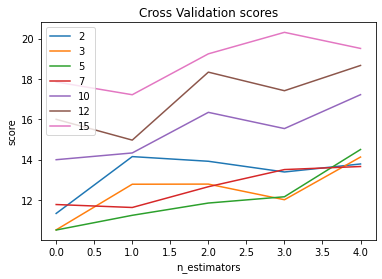

In [52]:
print('未降维')
#交叉验证
from sklearn import tree
from sklearn.model_selection import cross_val_score

scores = []
max_depths = [2,3,5,7,10,12,15]

for n in max_depths:
    clf = tree.DecisionTreeRegressor(max_depth=n,random_state=0)
    score = -cross_val_score(clf,X_train_sc,y_train,cv=5,scoring='neg_mean_squared_error')
    scores.append(score)
    
for i in scores:
    plt.plot(i)
plt.title('Cross Validation scores')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend(max_depths)

plt.show()

In [53]:
print('未降维 max_depth=5')
from sklearn import tree

clf = tree.DecisionTreeRegressor(max_depth=5,random_state=0)
clf = clf.fit(X_train_sc, y_train)

# 验证集
loss3 = -cross_val_score(clf, X_train_sc, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
clf = clf.fit(X_train_sc, y_train)
y_pred = clf.predict(X_test_sc)
mse3 = mse_loss(y_pred, y_test)
mape3, accuracy3, score3 = accuracy(y_pred, y_test)

print("回归树:Countencoder")
print("训练集mse:", loss3)
print("测试集mse:", mse3)
print("测试集mape:", mape3)
print("测试集accur:", accuracy3)
print("测试集score:",score3)

未降维 max_depth=5
回归树:Countencoder
训练集mse: 11.754110527354403
测试集mse: 11.319678265680626
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


#### ---------------------------我是分割线-------------------------------

## 5、随机森林

未降维
[array([11.52134812, 11.2811625 ,  9.66254031, 10.57867   , 10.43807562]), array([11.41045414, 11.22020836,  9.5680282 , 10.17057453, 10.32115438]), array([11.37076473, 11.22116096,  9.41285936, 10.10445621, 10.23417527]), array([11.33896938, 11.20322037,  9.42429066, 10.00855797, 10.20187667]), array([11.2947425 , 11.20360911,  9.38575204,  9.98086015, 10.23388961])]


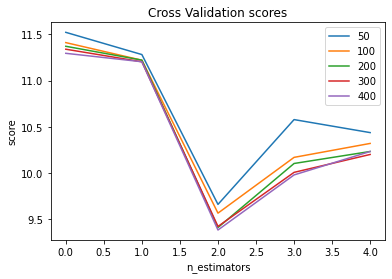

In [115]:
print('未降维')
#交叉验证
from sklearn.ensemble import RandomForestRegressor

scores = []
n_estimators = [100,200,300,400]

for n in n_estimators:
    forest = RandomForestRegressor(n_estimators=n,random_state=0)
    score = -cross_val_score(forest,X_train_sc,y_train,cv=5,scoring='neg_mean_squared_error')
    scores.append(score)
    
print(scores)    
for i in scores:
    plt.plot(i)
plt.title('Cross Validation scores')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend(n_estimators)

plt.show()

In [116]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=400, random_state=0)
rfr.fit(X_train_sc, y_train)

# 验证集
loss4 = -cross_val_score(rfr, X_train_sc, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = rfr.predict(X_test_sc)
mse4 = mse_loss(y_pred, y_test)
mape4, accuracy4, score4 = accuracy(y_pred, y_test)

print("随机森林:CountEncoder")
print("训练集mse:", loss4)
print("测试集mse:", mse4)
print("测试集mape:", mape4)
print("测试集accur:", accuracy4)
print("测试集score:",score4)

随机森林:CountEncoder
训练集mse: 10.428544778320312
测试集mse: 9.723242597656245
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


#### --------------------------------我是分割线---------------------------------------

低方差滤波
[array([11.57033531, 11.24623063,  9.79395094, 10.59858625, 10.44864937]), array([11.39111406, 11.21633437,  9.58645891, 10.19236813, 10.32337602]), array([11.27875562, 11.23655529,  9.48044271, 10.10310016, 10.2361182 ]), array([11.25700001, 11.21485793,  9.47008628,  9.99270295, 10.17041174]), array([11.23625286, 11.19539146,  9.42724688,  9.92796553, 10.23328458])]


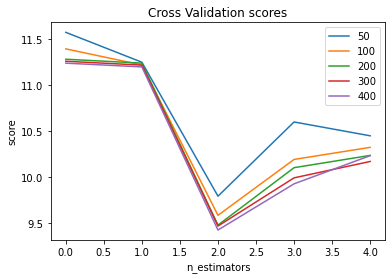

In [117]:
print('低方差滤波')
#交叉验证
from sklearn.ensemble import RandomForestRegressor

scores = []
n_estimators = [50,100,200,300,400]

for n in n_estimators:
    forest = RandomForestRegressor(n_estimators=n,random_state=0)
    score = -cross_val_score(forest,X_train_dp,y_train,cv=5,scoring='neg_mean_squared_error')
    scores.append(score)
    
print(scores)    
for i in scores:
    plt.plot(i)
plt.title('Cross Validation scores')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend(n_estimators)

plt.show()

In [118]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=400, random_state=0)
rfr.fit(X_train_dp, y_train)

# 验证集
loss4 = -cross_val_score(rfr, X_train_dp, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = rfr.predict(X_test_dp)
mse4 = mse_loss(y_pred, y_test)
mape4, accuracy4, score4 = accuracy(y_pred, y_test)

print("随机森林:低方差滤波")
print("训练集mse:", loss4)
print("测试集mse:", mse4)
print("测试集mape:", mape4)
print("测试集accur:", accuracy4)
print("测试集score:",score4)

随机森林:低方差滤波
训练集mse: 10.421124948242186
测试集mse: 9.74402552734374
测试集mape: inf
测试集accur: 0.0
测试集score: -inf


#### --------------------------------我是分割线---------------------------------------

特征选择
[array([11.05263388, 11.89927973,  9.25892803,  9.70660618, 10.63685195]), array([11.12772629, 11.99204741,  9.21700793,  9.77696628, 10.55458338]), array([11.18738941, 11.9125007 ,  9.19597947,  9.79695336, 10.53280304]), array([11.15020621, 11.93501847,  9.18465421,  9.74512058, 10.54140113]), array([11.1596026 , 11.95242314,  9.17708694,  9.76306208, 10.52139241])]


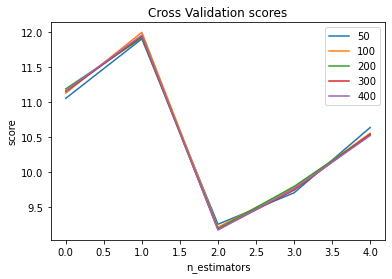

In [122]:
print('特征选择')
#交叉验证
from sklearn.ensemble import RandomForestRegressor

scores = []
n_estimators = [50,100,200,300,400]

for n in n_estimators:
    forest = RandomForestRegressor(n_estimators=n,random_state=0)
    score = -cross_val_score(forest,X_train_kb,y_train,cv=5,scoring='neg_mean_squared_error')
    scores.append(score)
    
print(scores)    
for i in scores:
    plt.plot(i)
plt.title('Cross Validation scores')
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.legend(n_estimators)

plt.show()

In [121]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=400, random_state=0)
rfr.fit(X_train_kb, y_train)

# 验证集
loss4 = -cross_val_score(rfr, X_train_kb, y_train, cv = 10, scoring='neg_mean_squared_error').mean()

# 训练集
y_pred = rfr.predict(X_test_kb)
mse4 = mse_loss(y_pred, y_test)
mape4, accuracy4, score4 = accuracy(y_pred, y_test)

print("随机森林:特征选择")
print("训练集mse:", loss4)
print("测试集mse:", mse4)
print("测试集mape:", mape4)
print("测试集accur:", accuracy4)
print("测试集score:",score4)

随机森林:特征选择
训练集mse: 10.418439561940959
测试集mse: 9.629900447920914
测试集mape: inf
测试集accur: 0.0
测试集score: -inf
